While the 1D Ising model does not yet feature a phase transition, the 2D Ising model already does. This can be seen e.g. in the analytical result for the absolute magnetisation per particle for $H = 0$:
\begin{equation} |m(T)| = \begin{cases}
     0 \qquad \qquad \qquad : \quad T>T_c\\
    \frac{(1+z^2)^{1/4}(1-6z^2+z^4)^{1/8}}{\sqrt{1-z^2}}: \quad T< T_c \quad z = e^{-2J/k_BT}\
    \end{cases} 
\end{equation}

where $T_c$ is the Curie temperature at which the phase transition occurs.
Implement a 2D Ising model on a square lattice with $n = \sqrt{N} = 30$ spins per side, again using periodic boundary conditions, $s_{n+1,j} = s_{1,j}$ and $s_{i,n+1} = s_{i,1}$, connecting opposite sides with each other. Calculate the absolute magnetisation of the model for $H = 0$ in dependence of the thermal energy kBT with the same techniques used for the 1D model. Note that more time might be needed to reach equilibrium. Discuss your results. Can you reproduce the predicted phase transition?


In [1]:
from google.colab import files


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import numba
from numba import njit
from scipy.ndimage import convolve, generate_binary_structure

from matplotlib import rc
rc('animation', html='html5')
plt.style.use('classic')
%matplotlib inline

In [3]:
# 30 by 30 grid
N = 30

In [4]:
init_random = np.random.random((N,N))
lattice_p = np.zeros((N, N))
lattice_p[init_random>=0.25] = 1
lattice_p[init_random<0.25] = -1

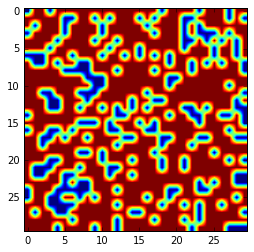

In [5]:
plt.imshow(lattice_p)

In [6]:
def get_energy(lattice):
    # applies the nearest neighbours summation
    kern = generate_binary_structure(2, 1) 
    kern[1][1] = False
    arr = -lattice * convolve(lattice, kern, mode='constant', cval=0)
    return arr.sum()

In [7]:
get_energy(lattice_p)

-904.0

In [8]:
@numba.njit("UniTuple(f8[:], 2)(f8[:,:], i8, f8, f8)", nopython=True, nogil=True)
def metropolis(spin_arr, times, BJ, energy):
    spin_arr = spin_arr.copy()
    net_spins = np.zeros(times-1)
    net_energy = np.zeros(times-1)
    for t in range(0,times-1):
        # 2. pick random point on array and flip spin
        x = np.random.randint(0,N)
        y = np.random.randint(0,N)
        spin_i = spin_arr[x,y] #initial spin
        spin_f = spin_i*-1 #proposed spin flip
        
        # compute change in energy
        E_i = 0
        E_f = 0
        if x>0:
            E_i += -spin_i*spin_arr[x-1,y]
            E_f += -spin_f*spin_arr[x-1,y]
        if x<N-1:
            E_i += -spin_i*spin_arr[x+1,y]
            E_f += -spin_f*spin_arr[x+1,y]
        if y>0:
            E_i += -spin_i*spin_arr[x,y-1]
            E_f += -spin_f*spin_arr[x,y-1]
        if y<N-1:
            E_i += -spin_i*spin_arr[x,y+1]
            E_f += -spin_f*spin_arr[x,y+1]
        
        # 3 / 4. change state with designated probabilities
        dE = E_f-E_i
        if (dE>0)*(np.random.random() < np.exp(-BJ*dE)):
            spin_arr[x,y]=spin_f
            energy += dE
        elif dE<=0:
            spin_arr[x,y]=spin_f
            energy += dE
            
        net_spins[t] = spin_arr.sum()
        net_energy[t] = energy
            
    return net_spins, net_energy

/usr/local/lib/python3.7/dist-packages/numba/core/decorators.py:253: RuntimeWarning: nopython is set for njit and is ignored
  warnings.warn('nopython is set for njit and is ignored', RuntimeWarning)


In [9]:
spins, energies = metropolis(lattice_p, 1000000, 0.2, get_energy(lattice_p))

In [10]:
def get_spin_energy(lattice, BJs):
    ms = np.zeros(len(BJs))
    E_means = np.zeros(len(BJs))
    E_stds = np.zeros(len(BJs))
    for i, bj in enumerate(BJs):
        spins, energies = metropolis(lattice, 1000000, bj, get_energy(lattice))
        ms[i] = np.abs(spins[-100000:]).mean()/N**2
        E_means[i] = energies[-100000:].mean()
        E_stds[i] = energies[-100000:].std()
    return ms, E_means, E_stds
    
BJs = np.arange(0.1, 2, 0.05)
#ms_n, E_means_n, E_stds_n = get_spin_energy(lattice_n, BJs)
ms_p, E_means_p, E_stds_p = get_spin_energy(lattice_p, BJs)

In [11]:
def analytical_m(T):
  m_abs = []
  J =1
  T_c = 2.269185*J
  for t in T:
    if t > T_c:
      m_abs.append(0)
    else:
      z = np.exp(-2*J/t)
      m_abs.append((1+z**2)**(1/4)*(1-6*z**2+z**4)**(1/8)/np.sqrt(1-z**2))
  return m_abs

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in double_scalars
  if __name__ == '__main__':


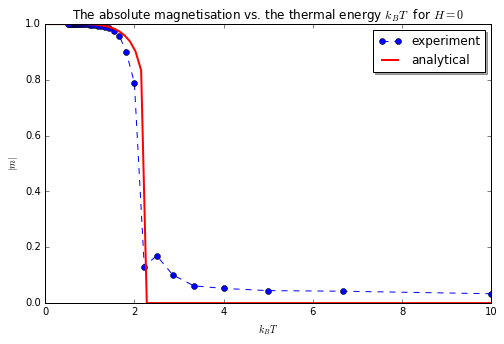

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<Figure size 432x288 with 0 Axes>

In [19]:
plt.figure(figsize=(8,5))
#plt.plot(1/BJs, ms_n, 'o--', label='75% of spins started negative')
plt.plot(1/BJs, ms_p, 'o--', label='experiment')
plt.plot(np.linspace(0, 10, 80), analytical_m(np.linspace(0, 10, 80)), label = 'analytical', color = 'r', linewidth = '2')
plt.xlabel(r'$k_B T$')
plt.ylabel(r'$|m|$')
plt.legend(facecolor='white', framealpha=1, shadow = True)
plt.title('The absolute magnetisation vs. the thermal energy $k_BT$  for $H = 0$')
plt.show()
plt.savefig("abc.png")
files.download("abc.png") 